In [1]:
from typing import Any
import os
import math
from evaluation.step_eval import FileEval, ATTEMPTS_NAME, StepAttempt
from evaluation.step_eval_analysis import FileEvalSmall, SmallAttempt, get_eval_file
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/coq-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-03 22:29:27,464] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
files = [
   ("Basic 8 pct", "/home/ubuntu/coq-modeling/step-evals/basic-rnd-split-rnd-samp-8-pct"),
   ("Premise 8 pct", "/home/ubuntu/coq-modeling/step-evals/premise-rnd-split-rnd-samp-8-pct"),
   ("Proof Ret 8 pct", "/home/ubuntu/coq-modeling/step-evals/codellama-7b-proof-ret-rnd-split-rnd-samp-8-pct"),
   # ("Thm Premises 8 pct", "/home/ubuntu/coq-modeling/step-evals/thm-premise-rnd-split-rnd-samp-8-pct"),
   # ("Fixed Premises 8 pct", "/home/ubuntu/coq-modeling/step-evals/fixed-premise-rnd-split-rnd-samp-8-pct"),
   #("Ground Truth Included", "/home/ubuntu/coq-modeling/step-evals/codellama-7b-basic-ground-truth-rnd-split-rnd-samp-8-pct"),
   #("Unimath-trained", "/home/ubuntu/coq-modeling/unimath-step-eval/codellama-7b-basic-unimath"),
   #("Whole-corpus trained", "/home/ubuntu/coq-modeling/unimath-step-eval/codellama-7b-basic"),
   #("Optimal Premises 8 pct", "/home/ubuntu/coq-modeling/step-evals/opt-premise-rnd-split-rnd-samp-8-pct"),
   #("Optimal Lemma Premises 8 pct", "/home/ubuntu/coq-modeling/step-evals/codellama-7b-opt-thm-premise-rnd-split-rnd-samp-8-pct"),
]

In [3]:
def get_shared_files_and_avgs(stats_by_eval: list[dict[str, FileEvalSmall]]) -> dict[str, float]:
    assert len(stats_by_eval) > 0
    new_key_set = set(stats_by_eval[0].keys())
    for file_stats_dic in stats_by_eval[1:]:
        new_key_set &= set(file_stats_dic.keys())
    
    file_avgs: dict[str, float] = {}
    for key in new_key_set:
        total_steps = 0
        for eval_stats in stats_by_eval:
            total_steps += len(eval_stats[key].attempts)
        file_avgs[key] = total_steps / len(stats_by_eval)
    return file_avgs

In [4]:
def get_eval_files(eval_dir: str) -> dict[str, FileEvalSmall]:
    attempts_loc = os.path.join(eval_dir, ATTEMPTS_NAME)
    file_stats_map: dict[str, FileEvalSmall] = {}
    for dp_name in os.listdir(attempts_loc):
        file_stats = get_eval_file(eval_dir, dp_name)
        file_stats_map[dp_name] = file_stats
    return file_stats_map 

In [5]:
def get_files_from_dict(eval_dict: dict[str, FileEvalSmall], files: list[str]) -> list[FileEvalSmall]:
    ret_files: list[FileEvalSmall] = []
    for file in files:
        ret_files.append(eval_dict[file])
    return ret_files


In [6]:
eval_objs = [get_eval_files(d) for _, d in files]
shared_files = get_shared_files_and_avgs(eval_objs)
eval_relevent_files = [get_files_from_dict(eval_dict, list(shared_files.keys())) for eval_dict in eval_objs]

Text(0.5, 1.0, 'Correct Step Rate by File for Longest Files in Val Set')

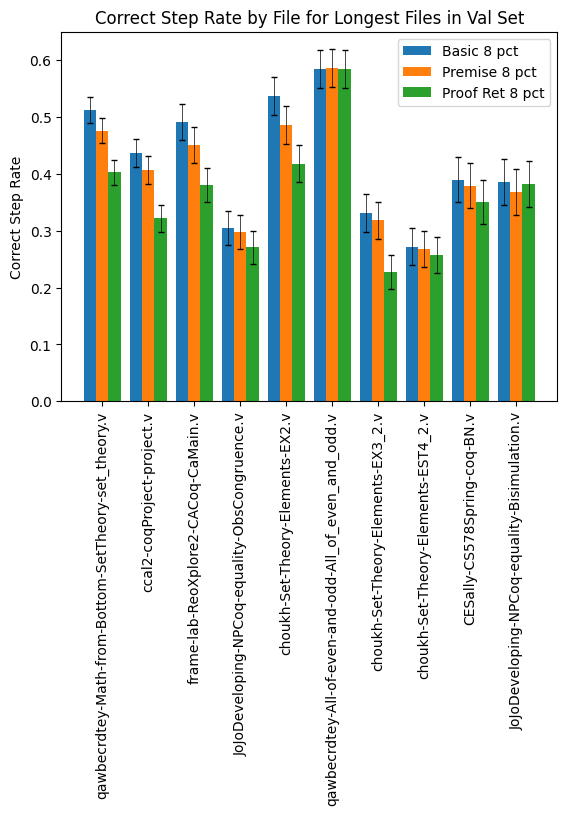

In [7]:
file_ordered_tups = sorted(shared_files.items(), key=lambda x: -1 * x[1]) 
sorted_files = [f for f, _ in file_ordered_tups]

top_k = 1
plot_top_files = 10
plot_files = sorted_files[:plot_top_files]
bar_width = 0.8 / len(eval_objs) 
fig, ax = plt.subplots()
xs = np.arange(len(plot_files))
for i, eval_dict in enumerate(eval_objs):
    vals: list[float] = []
    errs: list[float] = []
    for file in plot_files:
        vals.append(eval_dict[file].correct_at(top_k - 1))
        errs.append(eval_dict[file].correct_at_margin(top_k - 1))
    shift_factor = bar_width * (i - (len(eval_objs) // 2))
    if len(eval_objs) % 2 == 0:
        shift_factor += bar_width / 2
    
    plot_xs = xs + shift_factor
    ax.bar(plot_xs, vals, bar_width, label=files[i][0])
    ax.errorbar(plot_xs, vals, yerr=errs, fmt="none", ecolor="black", capsize=2, elinewidth=0.5)
ax.set_xticks(np.arange(len(plot_files)))
ax.set_xticklabels(plot_files, rotation=90)
ax.set_ylabel("Correct Step Rate")
ax.legend()
ax.set_title("Correct Step Rate by File for Longest Files in Val Set")
    
    


## Total Stats

In [8]:
def get_avg_and_err_at_k(eval_files: list[FileEval], k: int) -> tuple[float, float]:
    correct_steps = 0
    attempted_steps = 0
    for file in eval_files:
        for step in file.step_attempts:
            if step.is_correct_at_k(k):
                correct_steps += 1
            attempted_steps += 1
    rate = correct_steps / attempted_steps 
    err = 1.96 * math.sqrt(rate * (1 - rate) / attempted_steps)
    return rate, err

In [9]:
# Correct step rate when premise or no premise
# Same exact plot but with filtered steps

def get_step_avg_and_err_at_k(attempts: list[SmallAttempt], k: int) -> tuple[float, float]:
    correct_steps = 0
    attempted_steps = 0
    for step in attempts:
        if step.is_correct_at_k(k):
            correct_steps += 1
        attempted_steps += 1
    rate = correct_steps / attempted_steps 
    err = 1.96 * math.sqrt(rate * (1 - rate) / attempted_steps)
    return rate, err

def get_all_eval_steps(eval_files: list[FileEvalSmall]) -> list[SmallAttempt]:
    step_attempts: list[SmallAttempt] = []
    for eval_file in eval_files:
        step_attempts.extend(eval_file.attempts)
    return step_attempts

def filter_premise_steps(attempts: list[SmallAttempt]) -> list[SmallAttempt]:
    premise_attempts: list[SmallAttempt] = []
    for attempt in attempts:
        if attempt.ground_truth_has_premise[0]:
            premise_attempts.append(attempt)
    return premise_attempts

def filter_no_premise_steps(attempts: list[SmallAttempt]) -> list[SmallAttempt]:
    no_premise_attempts: list[SmallAttempt] = []
    for attempt in attempts:
        if not attempt.ground_truth_has_premise[0]:
            no_premise_attempts.append(attempt)
    return no_premise_attempts

AXIS = Any
def plot_step_acc_at_k(attempts_by_eval: list[list[SmallAttempt]], title: str, top_k: int=8) -> AXIS:
    bar_width = 0.8 / len(eval_objs) 
    fig, ax = plt.subplots()
    xs = np.arange(top_k)
    for i, eval_attempts in enumerate(attempts_by_eval):
        vals: list[float] = []
        errs: list[float] = []
        for k in range(top_k):
            val, err = get_step_avg_and_err_at_k(eval_attempts, k)
            vals.append(val)
            errs.append(err)
        shift_factor = bar_width * (i - (len(eval_objs) // 2))
        if len(eval_objs) % 2 == 0:
            shift_factor += bar_width / 2
        plot_xs = xs + shift_factor
        ax.bar(plot_xs, vals, bar_width, label=files[i][0])
        ax.errorbar(plot_xs, vals, yerr=errs, fmt="none", ecolor="black", capsize=2, elinewidth=0.5)
    ax.set_xticks(xs)
    xlabels = [str(x + 1) for x in xs]
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("Correct Step Rate")
    ax.set_xlabel("K = Number of Predictions")
    ax.legend()
    ax.set_title(title)


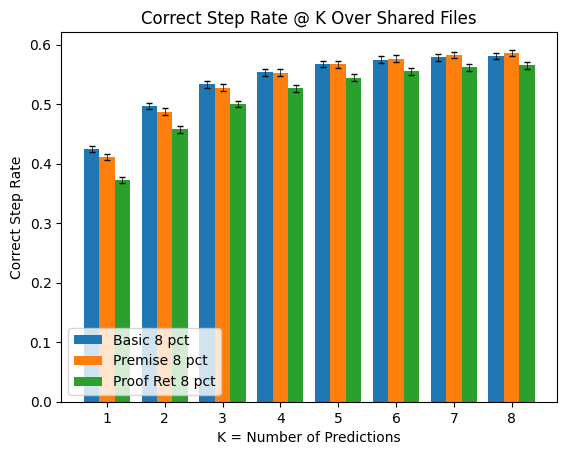

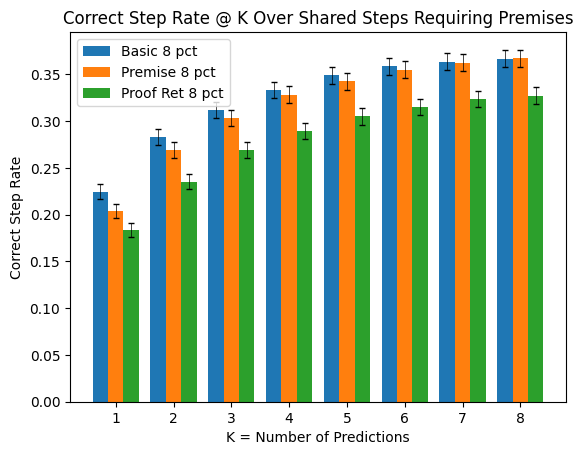

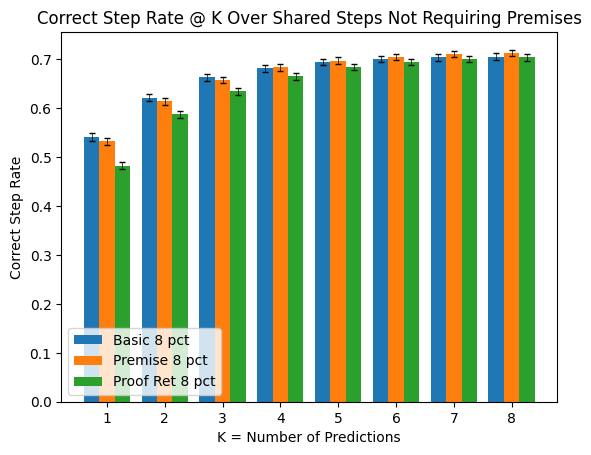

In [10]:
attempts_by_eval = [get_all_eval_steps(e_file_list) for e_file_list in eval_relevent_files]
plot_step_acc_at_k(attempts_by_eval, "Correct Step Rate @ K Over Shared Files")

premise_attempts_by_eval = [filter_premise_steps(steps) for steps in attempts_by_eval]
plot_step_acc_at_k(premise_attempts_by_eval, "Correct Step Rate @ K Over Shared Steps Requiring Premises")

no_premise_attempts_by_eval = [filter_no_premise_steps(steps) for steps in attempts_by_eval]
plot_step_acc_at_k(no_premise_attempts_by_eval, "Correct Step Rate @ K Over Shared Steps Not Requiring Premises")

# premise_plot = plot_step_acc_at_k(attempts_by_eval, "Correct Step Rate @ K Over Shared Files")

